In [2]:
import os
import time
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser

# Téléchargement des PDB supplémentaires
os.makedirs("receptors", exist_ok=True)
pdb_ids = ["1DMP", "2XJX", "7PG9", "1SYH", "4LDE", "6Y2F"]
for pdb in pdb_ids:
    if not os.path.exists(f"receptors/{pdb}.pdb"):
        os.system(f"wget -O receptors/{pdb}.pdb https://files.rcsb.org/download/{pdb}.pdb")

def compute_box_from_pdb(pdb_path, padding=6.0):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("receptor", pdb_path)
    atoms = [atom.coord for atom in structure.get_atoms() if atom.element != "H"]
    coords = np.array(atoms)
    min_corner = coords.min(axis=0)
    max_corner = coords.max(axis=0)
    center = coords.mean(axis=0)
    size = (max_corner - min_corner) + padding
    return center, size

def extract_affinity_from_log(log_file):
    affinity, found = None, False
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if found and re.match(r'^\s*1\s+-?\d+\.\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except Exception:
        pass
    return affinity

def run_docking_fallback(ligand_pdbqt, receptor_pdbqt, receptor_pdb, output_dir, try_tools=["smina", "vina"]):
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt', '')
    output_file = os.path.join(output_dir, base + '_out.pdbqt')
    log_file = os.path.join(output_dir, base + '.log')
    
    center, size = compute_box_from_pdb(receptor_pdb)
    cx, cy, cz = center
    sx, sy, sz = size

    for tool in try_tools:
        cmd = f"{tool} --receptor {receptor_pdbqt} --ligand {ligand_pdbqt} " \
              f"--center_x {cx:.2f} --center_y {cy:.2f} --center_z {cz:.2f} " \
              f"--size_x {sx:.1f} --size_y {sy:.1f} --size_z {sz:.1f} " \
              f"--out {output_file} --log {log_file} --exhaustiveness 100"
        t0 = time.time()
        os.system(cmd)
        duration = time.time() - t0

        affinity = extract_affinity_from_log(log_file)
        if affinity is not None:
            print(f"✅ {tool.upper()} réussi pour {base} ({affinity:.2f} kcal/mol, {duration:.1f}s)")
            return affinity, tool
        else:
            print(f"⚠️ {tool} a échoué pour {base}")
    return None, "Failed"


In [2]:
ALL_LIGANDS_DIR = "ligands_pdbqt"
RECEPTORS = {
    "HIV1protease": ("receptors/1DMP.pdbqt", "receptors/1DMP.pdb"),
    "Hsp90": ("receptors/2XJX.pdbqt", "receptors/2XJX.pdb"),
    "Proteasome": ("receptors/7PG9.pdbqt", "receptors/7PG9.pdb"),
    "Neurodegenerative_1SYH": ("receptors/1SYH.pdbqt", "receptors/1SYH.pdb"),
    "Malaria_COPD_4LDE": ("receptors/4LDE.pdbqt", "receptors/4LDE.pdb"),
    "COVID19_6Y2F": ("receptors/6Y2F.pdbqt", "receptors/6Y2F.pdb")
}


ligands = [f for f in os.listdir(ALL_LIGANDS_DIR) if f.endswith(".pdbqt")]
results = []

for lig in tqdm(ligands, desc="Docking total"):
    lig_path = os.path.join(ALL_LIGANDS_DIR, lig)
    result_row = {"Molecule": lig}
    for target, (rec_pdbqt, rec_pdb) in RECEPTORS.items():
        out_dir = os.path.join("results", target)
        affinity, method = run_docking_fallback(lig_path, rec_pdbqt, rec_pdb, out_dir)
        result_row[target] = affinity
        result_row[target + "_method"] = method
    results.append(result_row)

df = pd.DataFrame(results)
df.to_csv("docking_matrix.csv", index=False)
df.head()

Docking total:   0%|                                                                                                                 | 0/7 [00:00<?, ?it/s]

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1933689508

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


Docking total:  14%|██████████████▍                                                                                      | 1/7 [26:07<2:36:47, 1567.94s/it]

✅ SMINA réussi pour 1712 (-6.40 kcal/mol, 256.9s)
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -276679533

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| r

Docking total:  29%|█████████████████████████████▏                                                                        | 2/7 [28:21<1:00:22, 724.44s/it]

*

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -1.1       0.000      0.000    
2       -1.1       13.106     13.246   
3       -1.1       44.360     44.556   
4       -1.1       46.951     47.328   
5       -1.1       62.541     62.981   
6       -1.1       32.848     33.171   
7       -1.1       63.773     64.070   
8       -1.1       63.774     63.845   
9       -1.0       44.041     44.440   
Refine time 4.987
Loop time 8.595
✅ SMINA réussi pour 977 (-1.10 kcal/mol, 8.8s)
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite ap

Docking total:  43%|████████████████████████████████████████████▌                                                           | 3/7 [36:42<41:29, 622.36s/it]

*

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.5       0.000      0.000    
2       -4.5       19.484     22.082   
3       -4.4       50.683     53.271   
4       -4.4       48.021     49.602   
5       -4.3       50.806     53.442   
6       -4.3       50.184     51.489   
7       -4.3       50.399     52.969   
8       -4.3       18.948     21.720   
9       -4.2       50.630     52.608   
Refine time 50.080
Loop time 56.499
✅ SMINA réussi pour 17851 (-4.50 kcal/mol, 56.6s)
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please ci



Parse error on line 32 in file "ligands_pdbqt/7801.pdbqt": Unknown or inappropriate tag
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angstr

⚠️ smina a échoué pour 7801
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 7801
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

⚠️ smina a échoué pour 7801
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 7801
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || |



Parse error on line 32 in file "ligands_pdbqt/7801.pdbqt": Unknown or inappropriate tag
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angstr

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

⚠️ smina a échoué pour 7801
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 7801
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___ 



Parse error on line 32 in file "ligands_pdbqt/7801.pdbqt": Unknown or inappropriate tag
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angstr

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

⚠️ smina a échoué pour 7801
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 7801
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___ 

Docking total:  71%|██████████████████████████████████████████████████████████████████████████▎                             | 5/7 [43:47<13:07, 393.72s/it]

*

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.0       0.000      0.000    
2       -5.8       46.336     48.660   
3       -5.8       27.461     28.919   
4       -5.7       21.683     23.921   
5       -5.7       22.010     24.260   
6       -5.7       45.606     47.354   
7       -5.6       45.606     47.396   
8       -5.5       46.017     47.162   
9       -5.5       27.128     28.495   
Refine time 35.404
Loop time 43.844
✅ SMINA réussi pour 4550 (-6.00 kcal/mol, 44.0s)
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cit

Docking total:  86%|█████████████████████████████████████████████████████████████████████████████████████████▏              | 6/7 [51:08<06:49, 409.93s/it]

*

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.0       0.000      0.000    
2       -3.9       14.309     15.812   
3       -3.9       66.093     67.545   
4       -3.8       16.076     18.700   
5       -3.8       14.159     15.890   
6       -3.8       25.799     26.706   
7       -3.8       27.464     28.385   
8       -3.8       51.214     52.219   
9       -3.7       25.862     26.525   
Refine time 37.053
Loop time 44.859
✅ SMINA réussi pour 20778 (-4.00 kcal/mol, 45.0s)




Parse error on line 18 in file "ligands_pdbqt/11029.pdbqt": Unknown or inappropriate tag
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angst

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

⚠️ smina a échoué pour 11029
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 11029
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  __



Parse error on line 18 in file "ligands_pdbqt/11029.pdbqt": Unknown or inappropriate tag
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angst

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

⚠️ smina a échoué pour 11029
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 11029
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  __

    maximum number of binding modes to generate
  --min_rmsd arg (=1)        minimum RMSD between output poses
  --energy_range arg (=3)    maximum energy difference between the best binding
                             mode and the worst one displayed (kcal/mol)
  --spacing arg (=0.375)     grid spacing (Angstrom)
  --verbosity arg (=1)       verbosity (0=no output, 1=normal, 2=verbose)

Configuration file (optional):
  --config arg               the above options can be put here

Information (optional):
  --help                     display usage summary
  --help_advanced            display usage summary with advanced options
  --version                  display program version



⚠️ vina a échoué pour 11029




Parse error on line 18 in file "ligands_pdbqt/11029.pdbqt": Unknown or inappropriate tag
Command line parse error: unrecognised option '--log'

Correct usage:

Input:
  --receptor arg             rigid part of the receptor (PDBQT)
  --flex arg                 flexible side chains, if any (PDBQT)
  --ligand arg               ligand (PDBQT)
  --batch arg                batch ligand (PDBQT)
  --scoring arg (=vina)      scoring function (ad4, vina or vinardo)

Search space (required):
  --maps arg                 affinity maps for the autodock4.2 (ad4) or vina 
                             scoring function
  --center_x arg             X coordinate of the center (Angstrom)
  --center_y arg             Y coordinate of the center (Angstrom)
  --center_z arg             Z coordinate of the center (Angstrom)
  --size_x arg               size in the X dimension (Angstrom)
  --size_y arg               size in the Y dimension (Angstrom)
  --size_z arg               size in the Z dimension (Angst

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

⚠️ smina a échoué pour 11029
AutoDock Vina v1.2.5
⚠️ vina a échoué pour 11029


,Molecule,HIV1protease,HIV1protease_method,Hsp90,Hsp90_method,Proteasome,Proteasome_method,Neurodegenerative_1SYH,Neurodegenerative_1SYH_method,Malaria_COPD_4LDE,Malaria_COPD_4LDE_method,COVID19_6Y2F,COVID19_6Y2F_method
0,1712.pdbqt,-7.6,smina,-7.4,smina,-9.7,smina,-6.2,smina,-0.0,smina,-6.4,smina
1,977.pdbqt,-2.1,smina,-1.1,smina,-1.5,smina,-1.5,smina,0.0,smina,-1.1,smina
2,17851.pdbqt,-5.2,smina,-4.6,smina,-6.0,smina,-4.7,smina,-0.0,smina,-4.5,smina
3,7801.pdbqt,NaN,Failed,NaN,Failed,NaN,Failed,NaN,Failed,NaN,Failed,NaN,Failed
4,4550.pdbqt,-6.0,smina,-6.2,smina,-8.0,smina,-6.1,smina,-0.0,smina,-6.0,smina


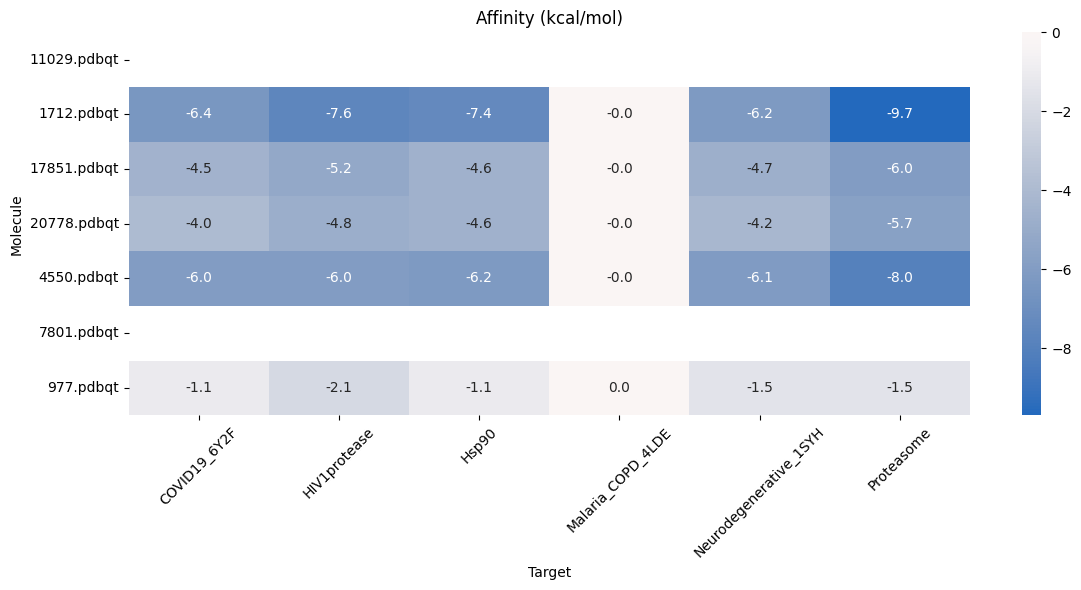

In [3]:
df = pd.read_csv("docking_matrix.csv")
aff_cols = [col for col in df.columns if col not in ["Molecule"] and not col.endswith("_method")]
df_long = df[["Molecule"] + aff_cols].melt(id_vars="Molecule", var_name="Target", value_name="Affinity")

plt.figure(figsize=(12, 6))
heatmap_data = df_long.pivot(index="Molecule", columns="Target", values="Affinity")
sns.heatmap(heatmap_data, cmap="vlag", center=0, annot=True, fmt=".1f")
plt.title("Affinity (kcal/mol)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()